**Author:** Vilius Kaulinskas, 2021

In [182]:
# Import required packages 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import warnings
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, ScalarFormatter, FormatStrFormatter
from matplotlib.dates import date2num
from datetime import datetime as dt2
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

import plotly.express as px
from pmdarima import auto_arima

# # for interactive figures, requires installation of ipympl
# %matplotlib ipympl  

%matplotlib inline
sns.set()

# Exploratory Data Analysis

In [3]:
features = pd.read_csv('../input/danskemy/features.csv')
sales = pd.read_csv('../input/danskemy/sales.csv')
stores = pd.read_csv('../input/danskemy/stores.csv')

## Data cleaning

### Sales

Sales data table for period between 2010-02-05 and 2010-10-26 with some stores data available until earlier date only. I convert dates into datetime format that is specific for munipulating dates in pandas.

For very small number of rows (0.003%), weekly sales are negative. It is unclear what is the meaning of such negative figures.

In [4]:
sales.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
sales['Date'] = pd.to_datetime(sales['Date'], format="%d/%m/%Y").dt.date
print('Sales data ranging from ' + min(sales['Date']) to max(sales['Date']))

### Features

In [12]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Features table contains missing values in columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI, Unemployment.

CPI and Unemployment details are missing for weeks from 03/05/2013 for all stores.

In [16]:
# For columns with promotion discounts where values are NaN, fill those cells with 0 
# as they indicate no promotion available:
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    features[col].fillna(0, inplace=True)

# Convert dates into datetime format that is specific for munipulating dates in pandas:
features['Date'] = pd.to_datetime(features['Date'], format="%d/%m/%Y").dt.date

# As per task description, current date is 2012-12-10. Features table has data available until 2013-07-26, 
# it is unclear how data later than 2012-12-10 is available. I assume throuhgout this report that this data is 
# FUTURE FORECAST. Thus, initially look at features period up to 2012-12-10:
features_until_now = features[features['Date'] <= datetime.date(2012, 12, 10)]

In [17]:
features_until_now

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8152,45,2012-11-09,41.20,3.771,2605.32,13041.23,17.84,640.33,2016.71,192.264988,8.667,False
8153,45,2012-11-16,45.61,3.750,18700.38,499.75,28.20,1800.78,10303.93,192.261619,8.667,False
8154,45,2012-11-23,43.08,3.748,1005.79,0.00,72542.01,484.70,620.12,192.283032,8.667,True
8155,45,2012-11-30,37.43,3.729,2298.55,0.00,2908.54,100.86,1344.84,192.304445,8.667,False


In [18]:
# Now we have no empty cells
features_until_now.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6705 entries, 0 to 8156
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6705 non-null   int64  
 1   Date          6705 non-null   object 
 2   Temperature   6705 non-null   float64
 3   Fuel_Price    6705 non-null   float64
 4   MarkDown1     6705 non-null   float64
 5   MarkDown2     6705 non-null   float64
 6   MarkDown3     6705 non-null   float64
 7   MarkDown4     6705 non-null   float64
 8   MarkDown5     6705 non-null   float64
 9   CPI           6705 non-null   float64
 10  Unemployment  6705 non-null   float64
 11  IsHoliday     6705 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 635.1+ KB


In [20]:
# Final dataframe looks as follows:
features_until_now

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8152,45,2012-11-09,41.20,3.771,2605.32,13041.23,17.84,640.33,2016.71,192.264988,8.667,False
8153,45,2012-11-16,45.61,3.750,18700.38,499.75,28.20,1800.78,10303.93,192.261619,8.667,False
8154,45,2012-11-23,43.08,3.748,1005.79,0.00,72542.01,484.70,620.12,192.283032,8.667,True
8155,45,2012-11-30,37.43,3.729,2298.55,0.00,2908.54,100.86,1344.84,192.304445,8.667,False


### Stores

In [21]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [22]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [23]:
# There are 3 store types
stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

## Data exploration

In [158]:
# Merge all dataframes into single large dataframe

full_df = pd.merge(sales, features, on=['Store', 'Date'], how='right')
full_df = pd.merge(full_df, stores, on=['Store'])
full_df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1.0,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,A,151315
1,1,2.0,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,A,151315
2,1,3.0,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,A,151315
3,1,4.0,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,A,151315
4,1,5.0,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423320,45,NaN,2013-06-28,NaN,NaN,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221
423321,45,NaN,2013-07-05,NaN,NaN,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221
423322,45,NaN,2013-07-12,NaN,NaN,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221
423323,45,NaN,2013-07-19,NaN,NaN,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221


In [ ]:
# Total weekly sales of every store and for every year seperately
total_weekly_sales_by_store = sales.groupby(['Store', 'Date'], axis=0, as_index=False).sum()
total_weekly_sales = total_weekly_sales_by_store.groupby(['Date'], axis=0, as_index=False).sum()
total_weekly_sales_Y2010 = total_weekly_sales[(total_weekly_sales['Date'] > datetime.date(2010, 1, 1)) & 
                                              (total_weekly_sales['Date'] < datetime.date(2010, 12, 31))]
total_weekly_sales_Y2011 = total_weekly_sales[(total_weekly_sales['Date'] > datetime.date(2011, 1, 1)) & 
                                              (total_weekly_sales['Date'] < datetime.date(2011, 12, 31))]
total_weekly_sales_Y2012 = total_weekly_sales[(total_weekly_sales['Date'] > datetime.date(2012, 1, 1)) & 
                                              (total_weekly_sales['Date'] < datetime.date(2012, 12, 31))]

# Total weekly sales for every department summed accross all stores
total_weekly_sales_by_department = sales.groupby(['Dept', 'Date'], axis=0, as_index=False).sum()

# Total weekly sales by store type
total_weekly_sales_by_type = pd.merge(total_weekly_sales_by_store, stores, on=['Store']).groupby(['Date', 'Type'], axis=0, as_index=False).sum()
total_weekly_sales_A = total_weekly_sales_by_type[total_weekly_sales_by_type['Type'] == 'A']
total_weekly_sales_B = total_weekly_sales_by_type[total_weekly_sales_by_type['Type'] == 'B']
total_weekly_sales_C = total_weekly_sales_by_type[total_weekly_sales_by_type['Type'] == 'C']

# Extract holiday week dates
holiday_weeks = full_df[['Date', 'IsHoliday_x']].dropna().groupby('Date', axis=0, as_index=False).first()
holiday_weeks = holiday_weeks[holiday_weeks['IsHoliday_x'] == True]

(14610.0, 15705.0)

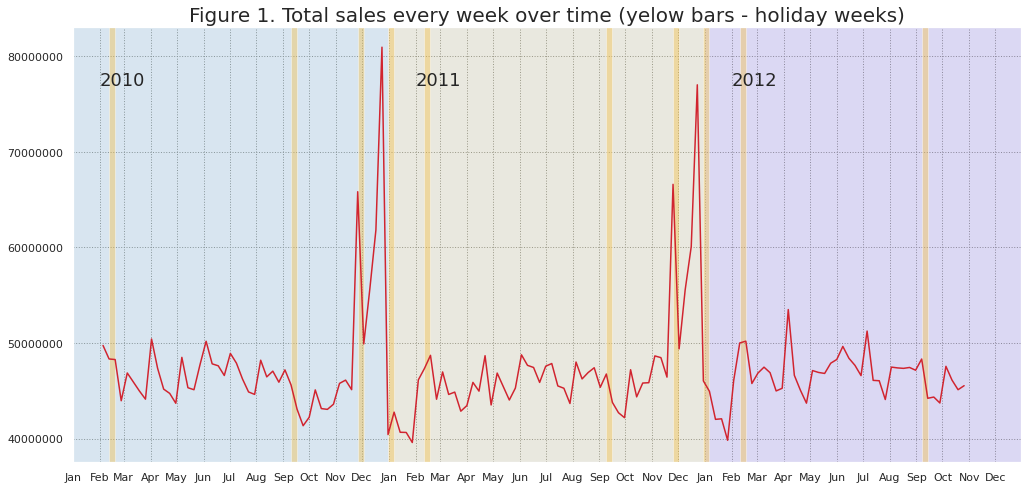

In [172]:
# Plot the data
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111)
plt.title('Figure 1. Total sales every week over time (yelow bars - holiday weeks)', size=20)

plt.axvspan(date2num(dt2(2010,1,1)), date2num(dt2(2010,12,31)), facecolor='#3abfe8', alpha=0.1)
plt.axvspan(date2num(dt2(2011,1,1)), date2num(dt2(2011,12,31)), facecolor='#e8da3a', alpha=0.1)
plt.axvspan(date2num(dt2(2012,1,1)), date2num(dt2(2012,12,31)), facecolor='#5e3dff', alpha=0.1)

plt.plot(total_weekly_sales.Date,  total_weekly_sales.Weekly_Sales, color='#d1242f')

holiday_weeks = full_df[['Date', 'IsHoliday_x']].dropna().groupby('Date', axis=0, as_index=False).first()
holiday_weeks = holiday_weeks[holiday_weeks['IsHoliday_x'] == True]
for i in holiday_weeks['Date']:
    plt.axvspan(date2num(i), date2num(i+pd.DateOffset(weeks=1)), facecolor='#f5bf42', alpha=0.4)
    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Set label as month name
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)
fmt_week = mdates.WeekdayLocator()
ax.xaxis.set_minor_locator(fmt_week)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# plt.grid(b=True, which='minor', color='b', linestyle=':')
plt.grid(b=True, which='major', color='#949494', linestyle=':')

ax.text(date2num(dt2(2010,2,1)), 77000000, '2010', fontsize=18)
ax.text(date2num(dt2(2011,2,1)), 77000000, '2011', fontsize=18)
ax.text(date2num(dt2(2012,2,1)), 77000000, '2012', fontsize=18)
ax.set_xlim([date2num(dt2(2010,1,1)), date2num(dt2(2012,12,31))])

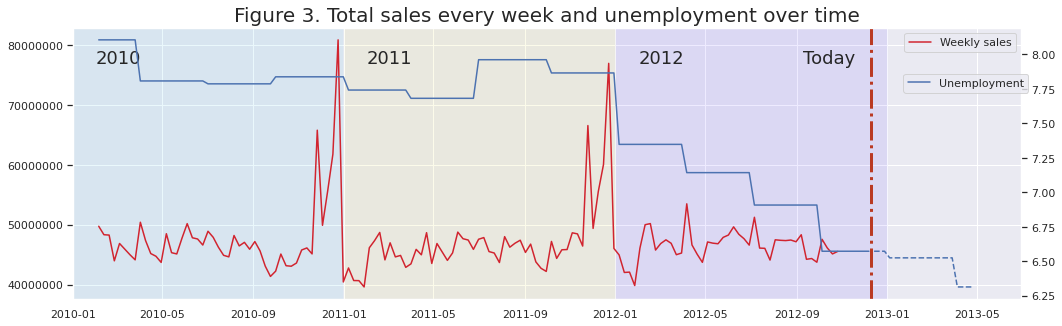

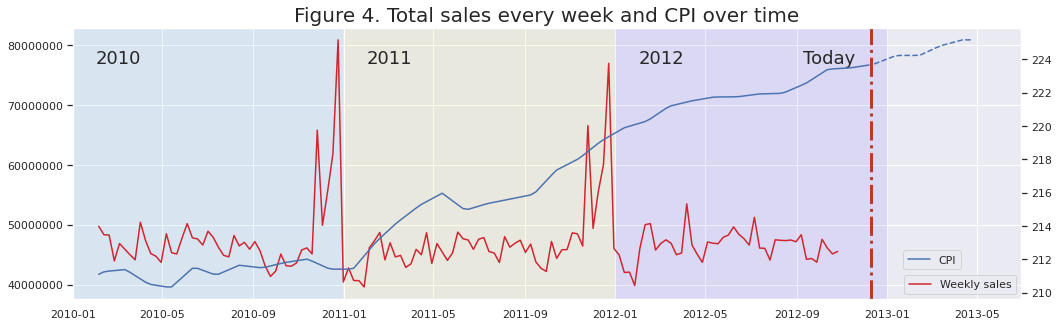

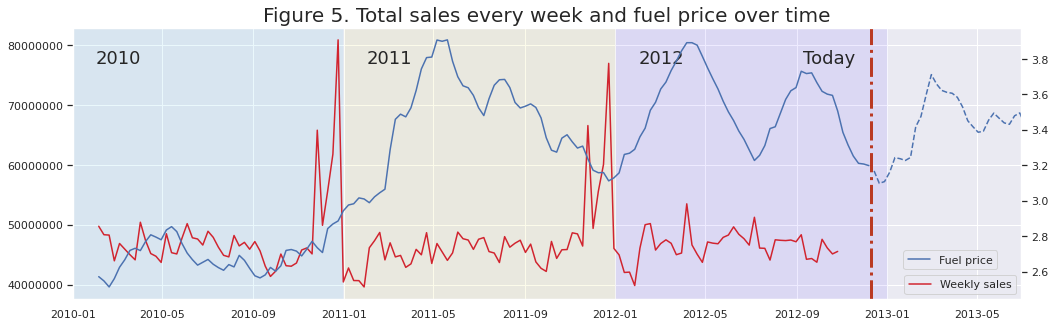

In [222]:
unemployment_history = full_df[['Date', 'Unemployment']].dropna().groupby('Date', axis=0, as_index=False).first()
unemployment_history

# Plot the data
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(111)

plt.title('Figure 3. Total sales every week and unemployment over time', size=20)
ax1.plot(total_weekly_sales.Date,  total_weekly_sales.Weekly_Sales, color='#d1242f', label='Weekly sales')

plt.axvspan(date2num(dt2(2010,1,1)), date2num(dt2(2010,12,31)), facecolor='#3abfe8', alpha=0.1)
plt.axvspan(date2num(dt2(2011,1,1)), date2num(dt2(2011,12,31)), facecolor='#e8da3a', alpha=0.1)
plt.axvspan(date2num(dt2(2012,1,1)), date2num(dt2(2012,12,31)), facecolor='#5e3dff', alpha=0.1)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Set label as month name
fmt_month = mdates.MonthLocator(interval=1)
ax1.xaxis.set_major_locator(fmt_month)
fmt_week = mdates.WeekdayLocator()
ax1.xaxis.set_minor_locator(fmt_week)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax1.text(date2num(dt2(2010,2,1)), 77000000, '2010', fontsize=18)
ax1.text(date2num(dt2(2011,2,1)), 77000000, '2011', fontsize=18)
ax1.text(date2num(dt2(2012,2,1)), 77000000, '2012', fontsize=18)
ax1.text(date2num(dt2(2012,9,10)), 77000000, 'Today', fontsize=18)
ax1.set_xlim([date2num(dt2(2010,1,1)), date2num(dt2(2013,6,30))])

ax2 = ax1.twinx()
solid = unemployment_history.Date < datetime.date(2012,12,10)
ax2.plot(unemployment_history.Date[solid], unemployment_history.Unemployment[solid], 'b', label='Unemployment')
ax2.plot(unemployment_history.Date[np.logical_not(solid)], unemployment_history.Unemployment[np.logical_not(solid)], 'b--')

plt.axvline(date2num(dt2(2012,12,10)), color='#ba3a23', linestyle='-.', linewidth=3)
plt.grid(b=None)
ax1.legend(loc=0)
ax2.legend(bbox_to_anchor=(0.87, 0.85), bbox_transform=ax2.transAxes)

plt.show()


cpi_history = full_df[['Date', 'CPI']].dropna().groupby('Date', axis=0, as_index=False).first()

# Plot the data
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(111)

plt.title('Figure 4. Total sales every week and CPI over time', size=20)
ax1.plot(total_weekly_sales.Date,  total_weekly_sales.Weekly_Sales, color='#d1242f', label='Weekly sales')

plt.axvspan(date2num(dt2(2010,1,1)), date2num(dt2(2010,12,31)), facecolor='#3abfe8', alpha=0.1)
plt.axvspan(date2num(dt2(2011,1,1)), date2num(dt2(2011,12,31)), facecolor='#e8da3a', alpha=0.1)
plt.axvspan(date2num(dt2(2012,1,1)), date2num(dt2(2012,12,31)), facecolor='#5e3dff', alpha=0.1)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Set label as month name
fmt_month = mdates.MonthLocator(interval=1)
ax1.xaxis.set_major_locator(fmt_month)
fmt_week = mdates.WeekdayLocator()
ax1.xaxis.set_minor_locator(fmt_week)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax1.text(date2num(dt2(2010,2,1)), 77000000, '2010', fontsize=18)
ax1.text(date2num(dt2(2011,2,1)), 77000000, '2011', fontsize=18)
ax1.text(date2num(dt2(2012,2,1)), 77000000, '2012', fontsize=18)
ax1.text(date2num(dt2(2012,9,10)), 77000000, 'Today', fontsize=18)
ax1.set_xlim([date2num(dt2(2010,1,1)), date2num(dt2(2013,6,30))])

ax2 = ax1.twinx()
solid = cpi_history.Date < datetime.date(2012,12,10)
ax2.plot(cpi_history.Date[solid], cpi_history.CPI[solid], 'b', label='CPI')
ax2.plot(cpi_history.Date[np.logical_not(solid)], cpi_history.CPI[np.logical_not(solid)], 'b--')

plt.axvline(date2num(dt2(2012,12,10)), color='#ba3a23', linestyle='-.', linewidth=3)
plt.grid(b=None)
ax1.legend(loc=4)
ax2.legend(bbox_to_anchor=(0.87, 0.2), bbox_transform=ax2.transAxes)

plt.show()


fuel_history = full_df[['Date', 'Fuel_Price']].dropna().groupby('Date', axis=0, as_index=False).first()

# Plot the data
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(111)

plt.title('Figure 5. Total sales every week and fuel price over time', size=20)
ax1.plot(total_weekly_sales.Date,  total_weekly_sales.Weekly_Sales, color='#d1242f', label='Weekly sales')

plt.axvspan(date2num(dt2(2010,1,1)), date2num(dt2(2010,12,31)), facecolor='#3abfe8', alpha=0.1)
plt.axvspan(date2num(dt2(2011,1,1)), date2num(dt2(2011,12,31)), facecolor='#e8da3a', alpha=0.1)
plt.axvspan(date2num(dt2(2012,1,1)), date2num(dt2(2012,12,31)), facecolor='#5e3dff', alpha=0.1)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Set label as month name
fmt_month = mdates.MonthLocator(interval=1)
ax1.xaxis.set_major_locator(fmt_month)
fmt_week = mdates.WeekdayLocator()
ax1.xaxis.set_minor_locator(fmt_week)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax1.text(date2num(dt2(2010,2,1)), 77000000, '2010', fontsize=18)
ax1.text(date2num(dt2(2011,2,1)), 77000000, '2011', fontsize=18)
ax1.text(date2num(dt2(2012,2,1)), 77000000, '2012', fontsize=18)
ax1.text(date2num(dt2(2012,9,10)), 77000000, 'Today', fontsize=18)
ax1.set_xlim([date2num(dt2(2010,1,1)), date2num(dt2(2013,6,30))])

ax2 = ax1.twinx()
solid = fuel_history.Date < datetime.date(2012,12,10)
ax2.plot(fuel_history.Date[solid], fuel_history.Fuel_Price[solid], 'b', label='Fuel price')
ax2.plot(fuel_history.Date[np.logical_not(solid)], fuel_history.Fuel_Price[np.logical_not(solid)], 'b--')

plt.axvline(date2num(dt2(2012,12,10)), color='#ba3a23', linestyle='-.', linewidth=3)
plt.grid(b=None)
ax1.legend(loc=4)
ax2.legend(bbox_to_anchor=(0.87, 0.2), bbox_transform=ax2.transAxes)

plt.show()

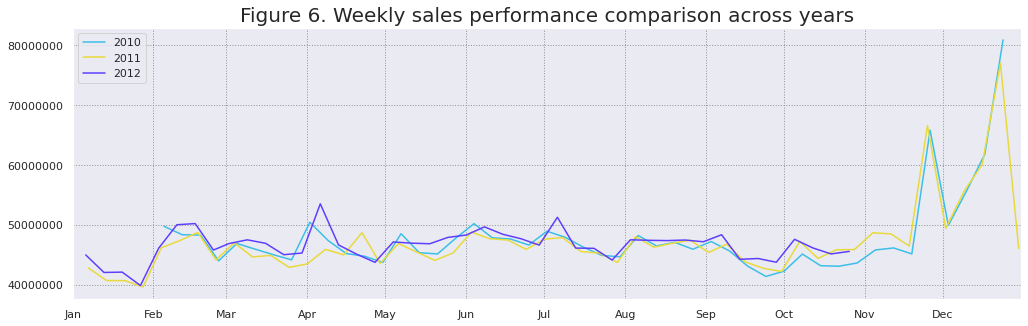

In [255]:
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(111)
plt.title('Figure 6. Weekly sales performance comparison across years', size=20)

plt.plot(total_weekly_sales_Y2010.Date,  total_weekly_sales_Y2010.Weekly_Sales, color='#3abfe8')
plt.plot(total_weekly_sales_Y2011.Date - pd.DateOffset(years=1) ,  total_weekly_sales_Y2011.Weekly_Sales, color='#e8da3a')
plt.plot(total_weekly_sales_Y2012.Date - pd.DateOffset(years=2),  total_weekly_sales_Y2012.Weekly_Sales, color='#5e3dff')

plt.grid(b=True, which='major', color='#949494', linestyle=':')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Set label as month name
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)
fmt_week = mdates.WeekdayLocator()
ax.xaxis.set_minor_locator(fmt_week)
ax.set_xlim([date2num(dt2(2010,1,1)), date2num(dt2(2010,12,31))])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.legend([2010,2011,2012])

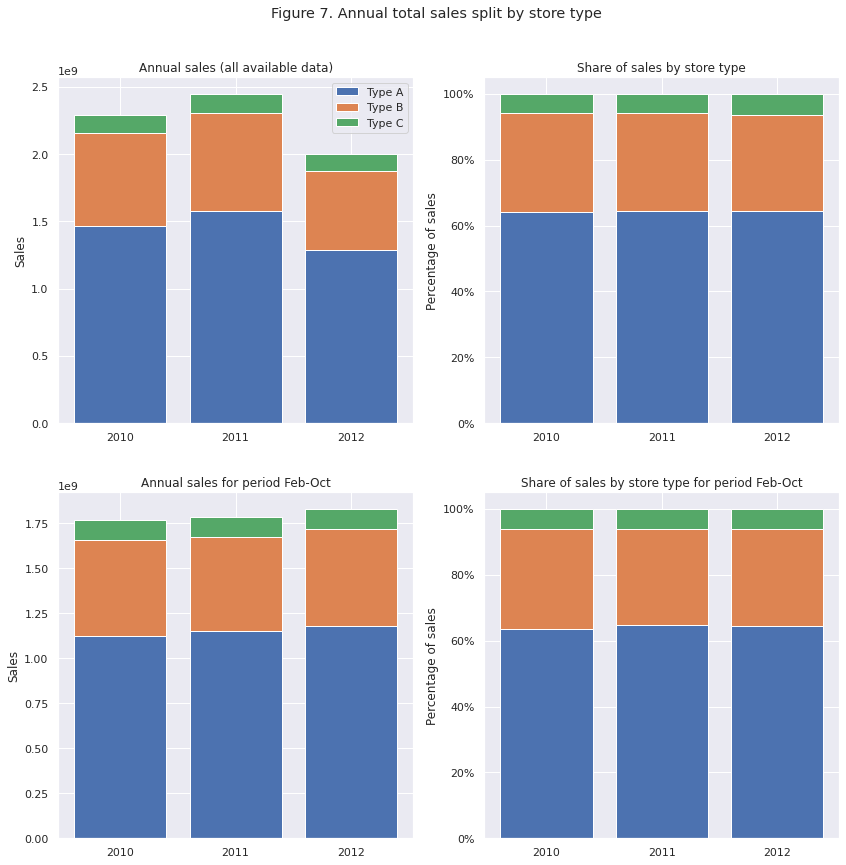

In [256]:
labels = ['2010', '2011', '2012']
sales_A_Oct_Feb = np.array([
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2010, 2, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2010, 10, 26))].Weekly_Sales.sum(),
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2011, 2, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2011, 10, 31))].Weekly_Sales.sum(),
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2012, 2, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2012, 10, 31))].Weekly_Sales.sum()])
sales_B_Oct_Feb = np.array([
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2010, 2, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2010, 10, 31))].Weekly_Sales.sum(),
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2011, 2, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2011, 10, 31))].Weekly_Sales.sum(),
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2012, 2, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2012, 10, 31))].Weekly_Sales.sum()])
sales_C_Oct_Feb = np.array([
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2010, 2, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2010, 10, 31))].Weekly_Sales.sum(),
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2011, 2, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2011, 10, 31))].Weekly_Sales.sum(),
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2012, 2, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2012, 10, 31))].Weekly_Sales.sum()])

sales_A = np.array([
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2010, 1, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2010, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2011, 1, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2011, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_A[(total_weekly_sales_A['Date'] >= datetime.date(2012, 1, 1)) & 
                         (total_weekly_sales_A['Date'] <= datetime.date(2012, 12, 31))].Weekly_Sales.sum()])
sales_B = np.array([
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2010, 1, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2010, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2011, 1, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2011, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_B[(total_weekly_sales_B['Date'] >= datetime.date(2012, 1, 1)) & 
                         (total_weekly_sales_B['Date'] <= datetime.date(2012, 12, 31))].Weekly_Sales.sum()])
sales_C = np.array([
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2010, 1, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2010, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2011, 1, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2011, 12, 31))].Weekly_Sales.sum(),
    total_weekly_sales_C[(total_weekly_sales_C['Date'] >= datetime.date(2012, 1, 1)) & 
                         (total_weekly_sales_C['Date'] <= datetime.date(2012, 12, 31))].Weekly_Sales.sum()])


width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

ax[0,0].bar(labels, sales_A, label='Type A')
ax[0,0].bar(labels, sales_B, bottom=sales_A,  label='Type B')
ax[0,0].bar(labels, sales_C, bottom=sales_A+sales_B,  label='Type C')
ax[0,0].set_ylabel('Sales')
ax[0,0].set_title('Annual sales (all available data)')
ax[0,0].legend()


a = ax[0,1].bar(labels, sales_A/(sales_A+sales_B+sales_C))
b = ax[0,1].bar(labels, sales_B/(sales_A+sales_B+sales_C), bottom=sales_A/(sales_A+sales_B+sales_C))
c = ax[0,1].bar(labels, sales_C/(sales_A+sales_B+sales_C), bottom=sales_A/(sales_A+sales_B+sales_C)+sales_B/(sales_A+sales_B+sales_C))
ax[0,1].set_ylabel('Percentage of sales')
ax[0,1].set_title('Share of sales by store type')
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


ax[1,0].bar(labels, sales_A_Oct_Feb, label='Type A')
ax[1,0].bar(labels, sales_B_Oct_Feb, bottom=sales_A_Oct_Feb,  label='Type B')
ax[1,0].bar(labels, sales_C_Oct_Feb, bottom=sales_A_Oct_Feb+sales_B_Oct_Feb,  label='Type C')
ax[1,0].set_ylabel('Sales')
ax[1,0].set_title('Annual sales for period Feb-Oct')


a = ax[1,1].bar(labels, sales_A_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
b = ax[1,1].bar(labels, sales_B_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb), 
                bottom=sales_A_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
c = ax[1,1].bar(labels, sales_C_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb), 
                bottom=sales_A_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb)+
                sales_B_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
ax[1,1].set_ylabel('Percentage of sales')
ax[1,1].set_title('Share of sales by store type for period Feb-Oct')
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

fig.suptitle('Figure 7. Annual total sales split by store type', y=0.95)

plt.show()

In [227]:
sales_2010 = sales_A_Oct_Feb[0] + sales_B_Oct_Feb[0] + sales_C_Oct_Feb[0]
sales_2011 = sales_A_Oct_Feb[1] + sales_B_Oct_Feb[1] + sales_C_Oct_Feb[1]
sales_2012 = sales_A_Oct_Feb[2] + sales_B_Oct_Feb[2] + sales_C_Oct_Feb[2]

In [ ]:
std_a = np.std(sales_A_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
std_b = np.std(sales_B_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
std_c = np.std(sales_C_Oct_Feb/(sales_A_Oct_Feb+sales_B_Oct_Feb+sales_C_Oct_Feb))
np.mean([std_a, std_b, std_c])

## Find correlations

Let's try to find some correlation between sales data and available variables.

In [36]:
# Merge all dataframes to have single large dataframe

full_df = pd.merge(sales, features_until_now, on=['Store', 'Date'])
full_df = pd.merge(full_df, stores, on=['Store'])
full_df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


In [35]:
correlation_df_markdowns = full_df[full_df['Date'] >= datetime.date(2010, 11, 11)]
correlation_df_markdowns

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
2869,1,1,2010-11-12,19549.39,False,59.61,2.728,0.00,0.00,0.0,0.00,0.00,212.003944,7.838,False,A,151315
2870,1,2,2010-11-12,43194.49,False,59.61,2.728,0.00,0.00,0.0,0.00,0.00,212.003944,7.838,False,A,151315
2871,1,3,2010-11-12,9146.77,False,59.61,2.728,0.00,0.00,0.0,0.00,0.00,212.003944,7.838,False,A,151315
2872,1,4,2010-11-12,35008.03,False,59.61,2.728,0.00,0.00,0.0,0.00,0.00,212.003944,7.838,False,A,151315
2873,1,5,2010-11-12,23698.89,False,59.61,2.728,0.00,0.00,0.0,0.00,0.00,212.003944,7.838,False,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221


Text(0.5, 1.03, 'Figure 8. Correlation between promotion amounts and weekly sales figures (for period from 2010-11-11)')

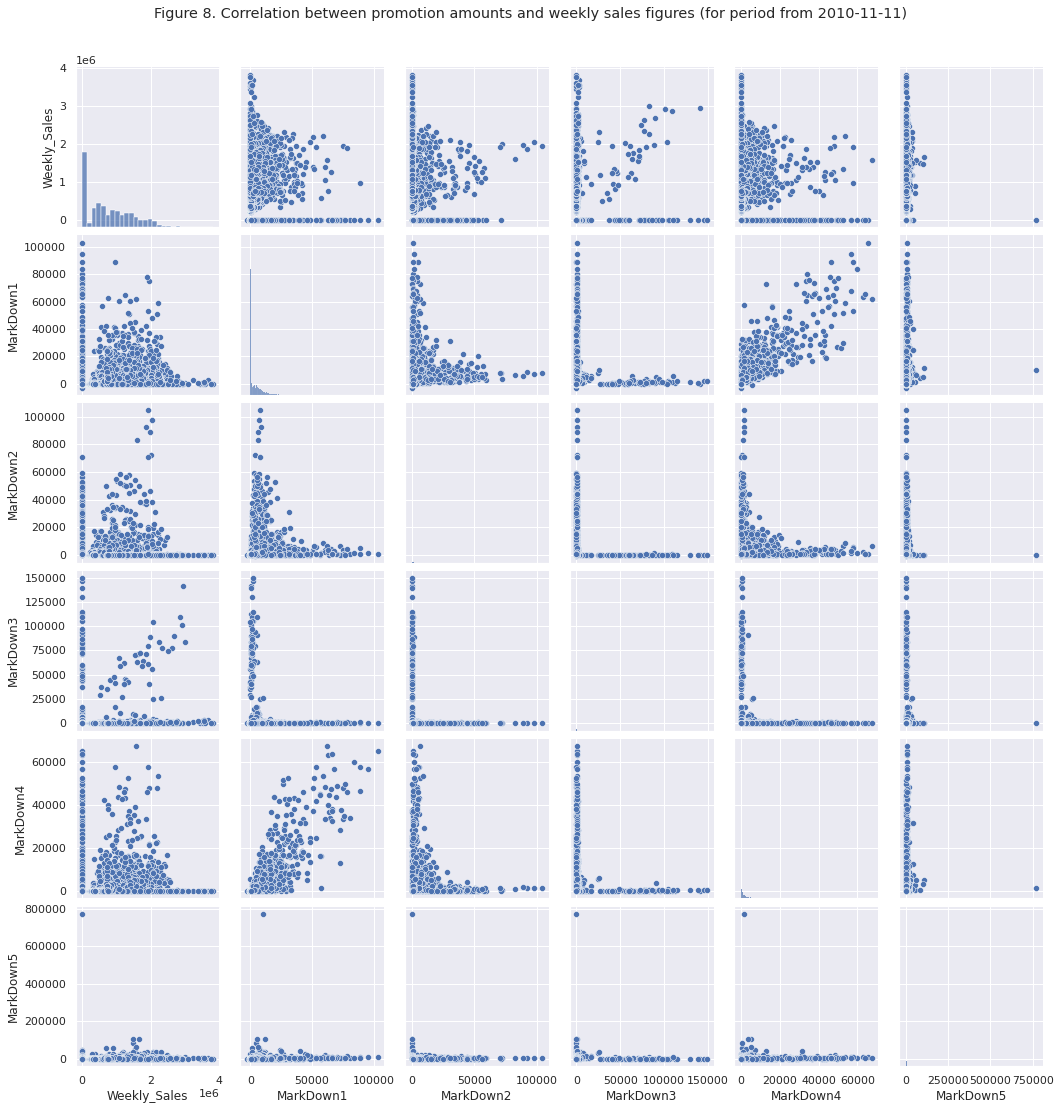

In [257]:
# Same promotion discounts (columns MarkDown 1-5) are applied across all departments in store.
correlation_df_sales_markdown = full_df.groupby(['Store', 'Date'], axis=0, as_index=False).agg({'Dept':'sum',
                                                                                                'Temperature': 'first',
                                                                                                'Fuel_Price': 'first',
                                                                                                'Weekly_Sales': 'sum',
                                                                                                'MarkDown1': 'first',
                                                                                                'MarkDown2': 'first',
                                                                                                'MarkDown3': 'first',
                                                                                                'MarkDown4': 'first',
                                                                                                'MarkDown5': 'first',
                                                                                                'CPI': 'first',
                                                                                                'Unemployment': 'first',
                                                                                                'Type': 'first',
                                                                                                'Size': 'first'})
correlation_df_sales_markdown = correlation_df_sales_markdown[correlation_df_sales_markdown['Date'] >= datetime.date(2010, 11, 11)]

# Draw correlation charts between sales and promotions
g = sns.pairplot(correlation_df_sales_markdown, vars = ['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']);
g.fig.suptitle('Figure 8. Correlation between promotion amounts and weekly sales figures (for period from 2010-11-11)', y=1.03)

Text(0.5, 1.03, 'Figure 9. Correlation between economic and other factors and weekly sales figures')

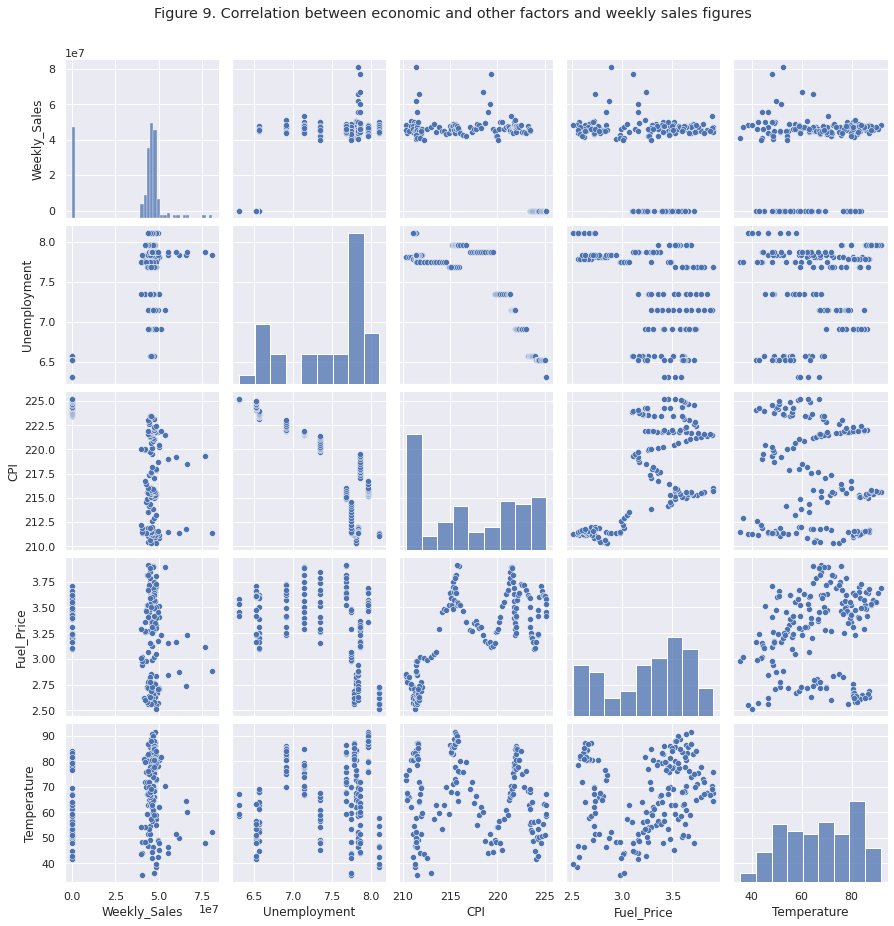

In [254]:
# Correlation between weekly sales and unemployment
correlation_df_sales_unemp = full_df.groupby(['Date'], axis=0, as_index=False).agg({            'Temperature': 'first',
                                                                                                'Fuel_Price': 'first',
                                                                                                'Weekly_Sales': 'sum',
                                                                                                'MarkDown1': 'first',
                                                                                                'MarkDown2': 'first',
                                                                                                'MarkDown3': 'first',
                                                                                                'MarkDown4': 'first',
                                                                                                'MarkDown5': 'first',
                                                                                                'CPI': 'first',
                                                                                                'Unemployment': 'first',
                                                                                   })
# Draw correlation charts between sales and promotions
g = sns.pairplot(correlation_df_sales_unemp, vars = ['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Temperature']);
g.fig.suptitle('Figure 9. Correlation between economic and other factors and weekly sales figures', y=1.03)

Text(0.5, 1.03, 'Figure 10. Impact of fuel price to weekly sales accross different store types')

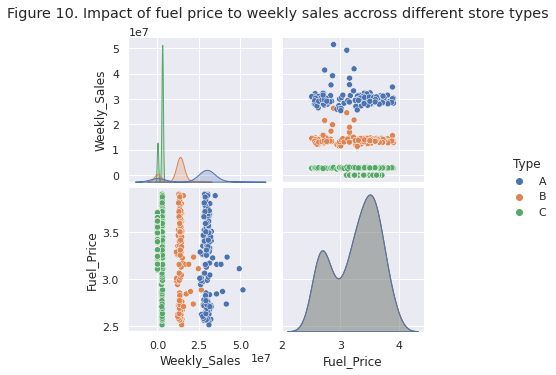

In [261]:
# Correlation between weekly sales and unemployment
correlation_df_sales_fuel = full_df.groupby(['Date','Type'], axis=0, as_index=False).agg({            'Temperature': 'first',
                                                                                                'Fuel_Price': 'first',
                                                                                                'Weekly_Sales': 'sum',
                                                                                                'MarkDown1': 'first',
                                                                                                'MarkDown2': 'first',
                                                                                                'MarkDown3': 'first',
                                                                                                'MarkDown4': 'first',
                                                                                                'MarkDown5': 'first',
                                                                                                'CPI': 'first',
                                                                                                'Unemployment': 'first',
#                                                                                                 'Type': 'first',
#                                                                                                 'Size': 'first'
                                                                                   })
# Draw correlation charts between sales and promotions
g = sns.pairplot(correlation_df_sales_fuel, vars = ['Weekly_Sales', 'Fuel_Price'], hue='Type', diag_kind='kde');
g.fig.suptitle('Figure 10. Impact of fuel price to weekly sales accross different store types', y=1.03)

In [281]:
# Revenue per unit of size for different types of stores
sales_per_unit = full_df.groupby(['Store'], axis=0, as_index=False).agg({            'Temperature': 'first',
                                                                                                'Fuel_Price': 'first',
                                                                                                'Weekly_Sales': 'sum',
                                                                                                'MarkDown1': 'first',
                                                                                                'MarkDown2': 'first',
                                                                                                'MarkDown3': 'first',
                                                                                                'MarkDown4': 'first',
                                                                                                'MarkDown5': 'first',
                                                                                                'CPI': 'first',
                                                                                                'Unemployment': 'first',
                                                                                                'Size': 'first',
                                                                                                 'Type': 'first'
                                                                                   })
sales_per_unit = sales_per_unit.groupby(['Type'], axis=0, as_index=False).agg({'Weekly_Sales': 'sum', 'Size': 'sum'})
sales_per_unit['Ratio'] = sales_per_unit['Weekly_Sales'] / sales_per_unit['Size']
sales_per_unit

,Type,Weekly_Sales,Size,Ratio
0,A,4.331015e+09,3899450,1110.673229
1,B,2.000701e+09,1720242,1163.034467
2,C,4.055035e+08,243250,1667.023751


# Key findings and suggestions to CFO

Sales date is incoming on Fridays. Since details for January of 2010 and November, December of 2011 were not available, when considering change in sales revenue over time, it is more accurate to compare only the time period for which data is available for all years (February - October). Figures 1-6 illustrate the change in weekly sales over time alongside other factors. We can see in figure 7 that retail sales have grown steadily throughout the years (2010-2012). Considering period February to October, from 2010 to 2011 total sales have grown by **0.96%** from 1.769B to 1.786B while from 2011 to 2012 growth reached **2.53%** yielding 1.831B in sales in 2012 Feb-Oct period. The share of sales across 3 store types has remained stable (mean standard deviation of change is 0.0034) with largest type A stores make up greatest proportion of sales income (approx. 64.5%), followed by type B (approx. 29.5%) and type C stores (approx. 6%). However, compared to type A and B shops, type C shops generate significantly more weekly revenue per one available item space in store (1667 compared to 1163 in type B and 1110 in type A stores). This could mean that these stores are most effective to run, however, since profitability data is not available, this hypothesis cannot be tested. Traditionally, Christmas period sees significantly higher sales figures, an outlier to otherwise steady sales folowed by the lowest sales of the year in January. Even though sales data isn't yet available for November and December 2012, there are no indications that this trend will not continue this December.

Economic forecasts (based on Features table) available until April - May of 2013 indicate positive economic climate. Even though unemployment rate has been relatively stable in both 2010 and 2011, this year (2012) it has been steadily decreasing, from 7.866 to 6.573. It is expected to further decrease to 6.314 by April. Although it does not appear that unemployment rate correlates with total sales, this is likely due to the fact that for the majority of time period unemployment rate has been steady and effects of decreasing rate can be lagging. In addition to that, Consumer Price Index (CPI), metric that indicates inflation level and purchasing power of consumer, has been steadily increasing from over past two years from 212 at the start 2011 to 224 currently with the forecast of further steady growth. These market conditions are favorable to our retail business and indicate potential growth in revenue.

Based on correlation graphs between 5 differnet promotions and sales figures (figure 7), it could be concluded that increasing the MarkDown3 promotion results in proportionately greater sales figures in those weeks. Promotions MarkDown1 and MarkDown4 are in general applied at the same time and their size is also correlated. MarkDown5 promotion does not have impact on weekly sales figures as these are quite uniformly distributed. It would be recommended to both carry on with succesful current promotions such as MarkDown2 and MarkDown3 that drive up sales and also experiment with new combinations of promotions in an attmept to increase sales even more. However, it is necessary to be careful not to lose money in the end when incraesed interest of buyers does not offset decrese in revenue due to discounts. Also, until now same promotions were being applied in all stores and departments at some time point. In order to be more flexible with sales model, next year we could vary promotions both by department as well as each store and whether that increases sales.

Contrary to intuition, factors such as unemployment and CPI do not seem to directly affect total weekly sales (figure 8). However, from figure 8 it can also be observed that decreasing unemployment correlates with increasing CPI and price of fuel, thus naturally the sales income of our business should also increase.

# Sales predictions for next year (2012-12-10 - 2013-12-10)
Predict using ARIMA model

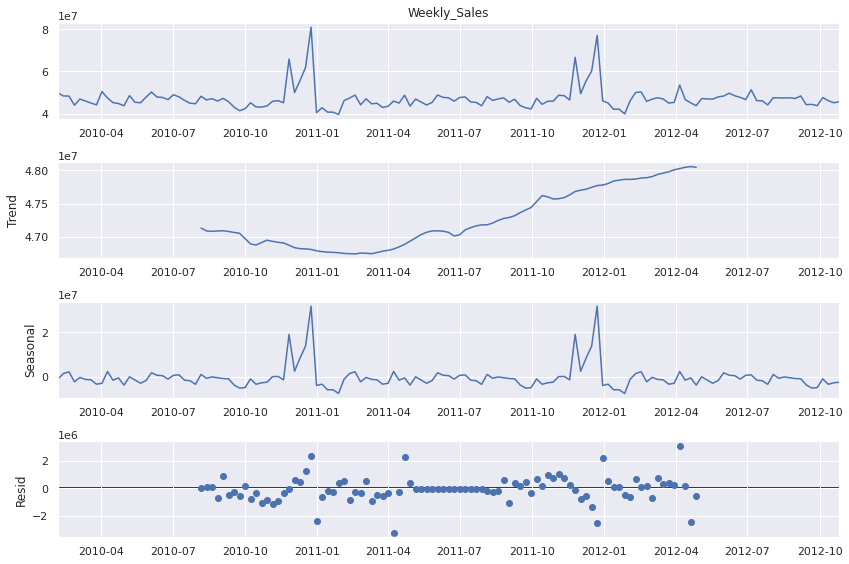

In [78]:
total_weekly_sales_dateind = total_weekly_sales.copy(deep=True)

total_weekly_sales_dateind['Date'] = pd.to_datetime(total_weekly_sales_dateind['Date'])
total_weekly_sales_dateind = total_weekly_sales_dateind.set_index('Date').asfreq('W-FRI')
result = seasonal_decompose(total_weekly_sales_dateind['Weekly_Sales'], model='ad')

from pylab import rcParams
rcParams['figure.figsize'] = 12,8
result.plot();

In [83]:
# Parameter Analysis for the ARIMA model
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(total_weekly_sales_dateind['Weekly_Sales'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=4509.799, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4552.670, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4521.393, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4530.532, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4551.192, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=4542.084, Time=0.12 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=4511.168, Time=0.66 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=4511.255, Time=2.29 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4516.801, Time=0.46 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=4513.079, Time=1.85 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=4515.372, Time=0.29 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=4512.394, Time=0.77 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=4501.646, Time=1.52 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=4533.399, Time=0.26 sec
 ARIMA(1,0,2)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  143
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2239.178
Date:                              Wed, 09 Jun 2021   AIC                           4492.356
Time:                                      17:42:33   BIC                           4512.483
Sample:                                           0   HQIC                          4500.535
                                              - 143                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5624      0.486      1.157      0.247      -0.390       1.515
ar.L2          0.7462      0.568      1.313      0.189      -0.368       1.860
ar.L3         -0.3209      0.134     -2.386      0.017      -0.584      -0.057
ma.L1         -0.1795      0.512     -0.350      0.726      -1.183       0.824
ma.L2         -0.6545      0.452     -1.448      0.148      -1.541       0.232
ma.S.L12      -0.8308      0.172     -4.837      0.000      -1.167      -0.494
sigma2      5.253e+13   3.15e-14   1.67e+27      0.000    5.25e+13    5.25e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.58   Jarque-Bera (JB):               181.13
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+43. Standard errors may be unstable.
"""

In [90]:
# Fit ARIMA Model to AirPassengers dataset
# Split data into train / test sets
train = total_weekly_sales_dateind.iloc[:len(total_weekly_sales_dateind)-52]
test = total_weekly_sales_dateind.iloc[len(total_weekly_sales_dateind)-52:] # set one year(12 months) for testing
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train['Weekly_Sales'], 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Weekly_Sales   No. Observations:                   91
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1340.822
Date:                            Wed, 09 Jun 2021   AIC                           2691.644
Time:                                    17:48:01   BIC                           2703.428
Sample:                                02-05-2010   HQIC                          2696.361
                                     - 10-28-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3284      0.087     -3.794      0.000      -0.498      -0.159
ar.S.L12       0.1306      0.355      0.368      0.713      -0.564       0.825
ar.S.L24      -0.0160      0.184     -0.087      0.931      -0.376       0.344
ma.S.L12      -0.7373      0.440     -1.677      0.093      -1.599       0.124
sigma2      6.519e+13   2.29e-14   2.84e+27      0.000    6.52e+13    6.52e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               271.19
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.86
Prob(H) (two-sided):                  0.08   Kurtosis:                        11.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.62e+42. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

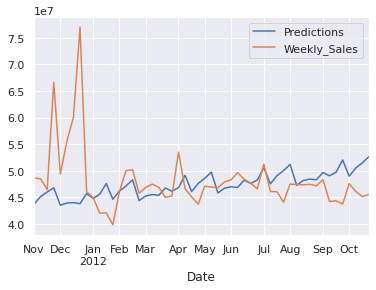

In [91]:
# Predictions of ARIMA Model against the test set

start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['Weekly_Sales'].plot(legend = True)

In [93]:
# Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
root_error = rmse(test["Weekly_Sales"], predictions)
  
# Calculate mean squared error
mean_error = mean_squared_error(test["Weekly_Sales"], predictions)

print(root_error)
print(mean_error)

6850813.870721057
46933650691264.03


<AxesSubplot:xlabel='Date'>

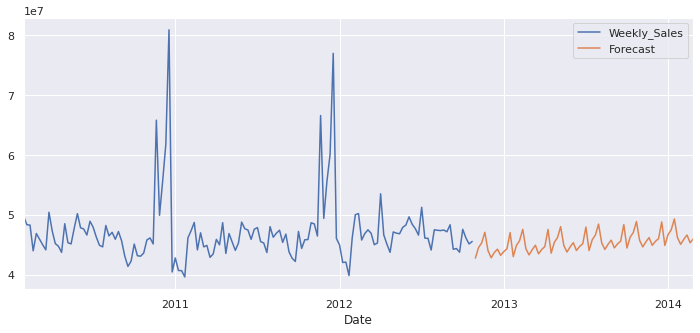

In [98]:
# Forecast using ARIMA Model

# Train the model on the full dataset
model = model = SARIMAX(total_weekly_sales_dateind['Weekly_Sales'], 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 1 years
forecast = result.predict(start = len(total_weekly_sales_dateind), 
                          end = (len(total_weekly_sales_dateind)-1) + 52, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
total_weekly_sales_dateind['Weekly_Sales'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)